In [1]:
from cssmodel.simulation import *
import os.path as op
%matplotlib inline
import seaborn as sns
from joblib.parallel import Parallel, delayed
import seaborn as sns
sns.set_style('white')

In [2]:
task = 'face'

In [4]:
rois = ['V1', 'V2', 'V3', 'hV4', 'IOG', 'pFus', 'mFus']
data = dict()
for h in ['L', 'R']:
    for roi in rois:
        roi_name = f'{h}{roi}'
        # remove the center from x, y so they're centered in (0, 0)
        if task == 'estimation':
            fnparam = f'../vtcdata/output/{roi_name}_median_param.txt'
        else:
            fnparam = f'../vtcdata/output/{roi_name}_facetask_median_param.txt'
        dt = np.loadtxt(fnparam)
        dt[:2] -= 50
        data[roi_name] = dt
data_combined = dict()
for roi in rois:
    data_combined[roi] = np.hstack((data[f'L{roi}'], data[f'R{roi}']))

In [3]:
def eccentricity(x, y, res=100, width_degree=12.5, remove_center=False):
    if remove_center:
        m = res/2.
        x = x - m
        y = y - m
    px2deg = width_degree/res
    x = x*px2deg
    y = y*px2deg
    return np.sqrt(x**2 + y**2)

def prf_size(sd, n, res=100, width_degree=12.5):
    px2deg = width_degree/res
    return px2deg * sd/np.sqrt(n)

In [5]:
ecc_size = dict()
for roi, pp in data.items():
    ecc_size[roi] = np.vstack((eccentricity(*pp[:2]), prf_size(pp[2], pp[4])))

In [7]:
from matplotlib.patches import Ellipse

def draw_stimuli(ax, scale=4., res=100):
    x0 = y0 = res // 2
    w = 4 * scale
    h = 4 * scale
    xpos = np.array((5, -5, -5, 5)) * scale + x0
    ypos = np.array((5, 5, -5, -5)) * scale + y0
    els = [
        Ellipse([x, y], width=w, height=h, facecolor='white', alpha=0.8) for x, y in zip(xpos, ypos)]
    for e in els:
        e.set_clip_box(ax.bbox)
        ax.add_artist(e)

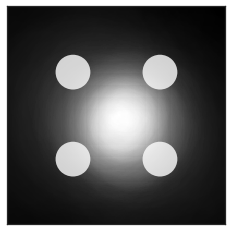

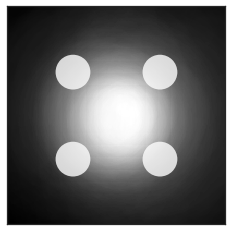

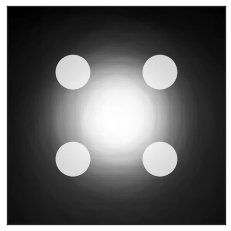

In [20]:
for roi in ['IOG', 'pFus', 'mFus']:
    fig, ax = plt.subplots(1, 1)
    dt = data_combined[roi]
    plot_prfdensity(dt[1], dt[0], dt[2], n=dt[-1], ax=ax, res=200)
    for l in ax.lines:
        l.set_visible(False)
    draw_stimuli(ax, scale=8, res=200)
    ax.set_xticklabels([]);
    ax.set_yticklabels([]);
    
    fig.savefig(f'img/example_popcoverage_{roi}.png', dpi=300)

In [152]:
def prfdensity(xs, ys, sigmas, n=0.2, res=100, binarize=True):
    """
    Compute coverage of a population of voxels

    Parameters
    ----------
    xs : array (n_voxels)
        centers
    ys : array (n_voxels)
        centers
    sigmas : array (n_voxels)
        std pRfs
    n : float or array (n_voxels)
        power exponent
    res : int
        size of one of the sides
    binarize : bool
        whether to binarize prior to adding up

    Returns
    -------
    density : array (res, res)
        each pixel contains a value between 0 and 1 representing
        the normalized number of voxels whose RF cover that pixel
    """
    x0 = y0 = res // 2
    xs = np.asarray(xs) + x0
    ys = np.asarray(ys) + y0

    if isinstance(n, float):
        n = np.array([n] * len(xs))

    f = np.zeros((res, res))
    for x, y, s, n_ in zip(xs, ys, sigmas, n):
        ff = filledprf(x, y, s, n=n_, res=res)
        if binarize:
            ff[ff <=0] = 0.
            ff[ff > 0] = 1.
        f += ff
    f /= len(xs)

    return f

Compute the proportion of voxels with receptive field covering the stimuli location

In [153]:
# from https://stackoverflow.com/questions/18352973/mask-a-circular-sector-in-a-numpy-array
def sector_mask(shape,centre,radius,angle_range):
    """
    Return a boolean mask for a circular sector. The start/stop angles in  
    `angle_range` should be given in clockwise order.
    """

    x,y = np.ogrid[:shape[0],:shape[1]]
    cx,cy = centre
    tmin,tmax = np.deg2rad(angle_range)

    # ensure stop angle > start angle
    if tmax < tmin:
            tmax += 2*np.pi

    # convert cartesian --> polar coordinates
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy)
    theta = np.arctan2(x-cx,y-cy) - tmin

    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)

    # circular mask
    circmask = r2 <= radius*radius

    # angular mask
    anglemask = theta <= (tmax-tmin)

    return circmask*anglemask

In [154]:
# compute stimuli location
res = 200
scale = 8.
x0 = y0 = res // 2
radius = 2 * scale
xpos = np.array((5, -5, -5, 5)) * scale + x0
ypos = np.array((5, 5, -5, -5)) * scale + y0
# xpos = np.array((0, 0, 0, 0)) * scale + x0
# ypos = np.array((0, 0, 0, 0)) * scale + y0

In [156]:
mask = [sector_mask(d.shape, (x, y), radius, (0, 361))
        for x, y in zip(xpos, ypos)]
[m.sum() for m in mask]

[797, 797, 797, 797]

In [157]:
density = dict()
for roi in rois:
    dt = data_combined[roi]
    d = prfdensity(dt[1], dt[0], dt[2], n=dt[-1], res=res)
    # make it a density
    # d /= d.sum()
    density[roi] = d

In [158]:
# now store the sum of densities in each stimulus area
density_stim = dict()
for roi in rois:
    v = 0.
    for m in mask:
        v += density[roi][m].sum()
    # normalize by the area of the stimuli (equivalent to computing the mean)
    density_stim[roi] = v / np.sum([m.sum() for m in mask])

So now `density_stim` contains the average proportion of voxels covering the stimulus location.

In [159]:
df = pd.DataFrame.from_dict(list(density_stim.items()))
df.columns = ['roi', 'percentage']
df['percentage'] *= 100
df.round(2)

,roi,percentage
0,V1,4.22
1,V2,6.69
2,V3,8.54
3,hV4,12.60
4,IOG,31.61
5,pFus,47.04
6,mFus,45.83
